# Analyzing Fair PCA on different datasets

## Exploratory Data Analysis

### Imports

In [2]:
from sklearn.model_selection import train_test_split
import dython
import numpy as np
import scipy.optimize as opt
import pandas as pd

In [145]:
df_recidivism = pd.read_csv(f'data/propublica_data_for_fairml.csv')

df_recidivism['Caucasian'] = ((df_recidivism['Other'] == 0) & (df_recidivism['African_American'] == 0) & (df_recidivism['Asian'] == 0) & (df_recidivism['Hispanic'] == 0) & (df_recidivism['Native_American'] == 0)).astype(int)
df_recidivism['Between_TwentyFive_And_FourtyFive'] = ((df_recidivism['Age_Above_FourtyFive'] == 0) & (df_recidivism['Age_Below_TwentyFive'] == 0)).astype(int)
df_recidivism['Male'] = (df_recidivism['Female'] == 0).astype(int)

# revert one hot encoding
races = ['Other', 'African_American', 'Asian', 'Hispanic', 'Native_American', 'Caucasian']
df_recidivism['Race'] = df_recidivism[races].idxmax(axis=1)
df_recidivism = df_recidivism.drop(races, axis=1)

genders = ['Female','Male']
df_recidivism['Gender'] = df_recidivism[genders].idxmax(axis=1)
df_recidivism = df_recidivism.drop(genders, axis=1)

age_group = ['Age_Above_FourtyFive', 'Age_Below_TwentyFive', 'Between_TwentyFive_And_FourtyFive']
df_recidivism['Age_Group'] = df_recidivism[age_group].idxmax(axis=1)
df_recidivism = df_recidivism.drop(age_group, axis=1)

df_recidivism = df_recidivism.drop('score_factor', axis=1)

In [146]:
df_recidivism = df_recidivism[df_recidivism["Race"].isin(["African_American", "Caucasian"])]

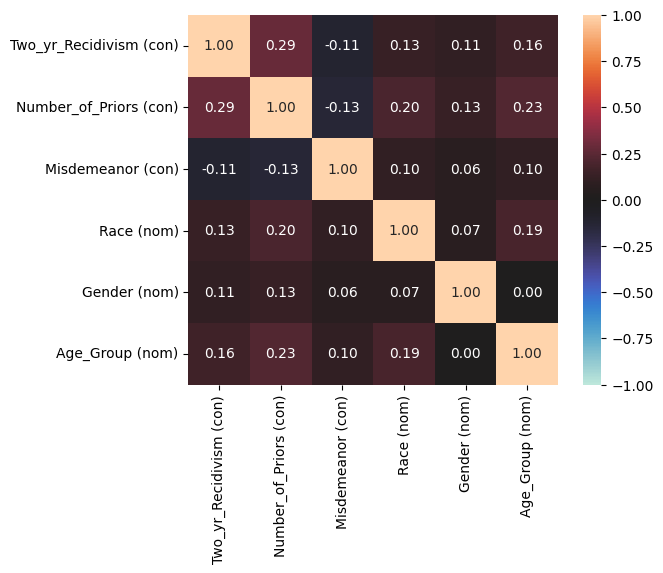

In [183]:
cat_cols = ["Race", "Gender", "Age_Group"]

dython.nominal.associations(df_recidivism, nominal_columns=cat_cols, mark_columns=True);

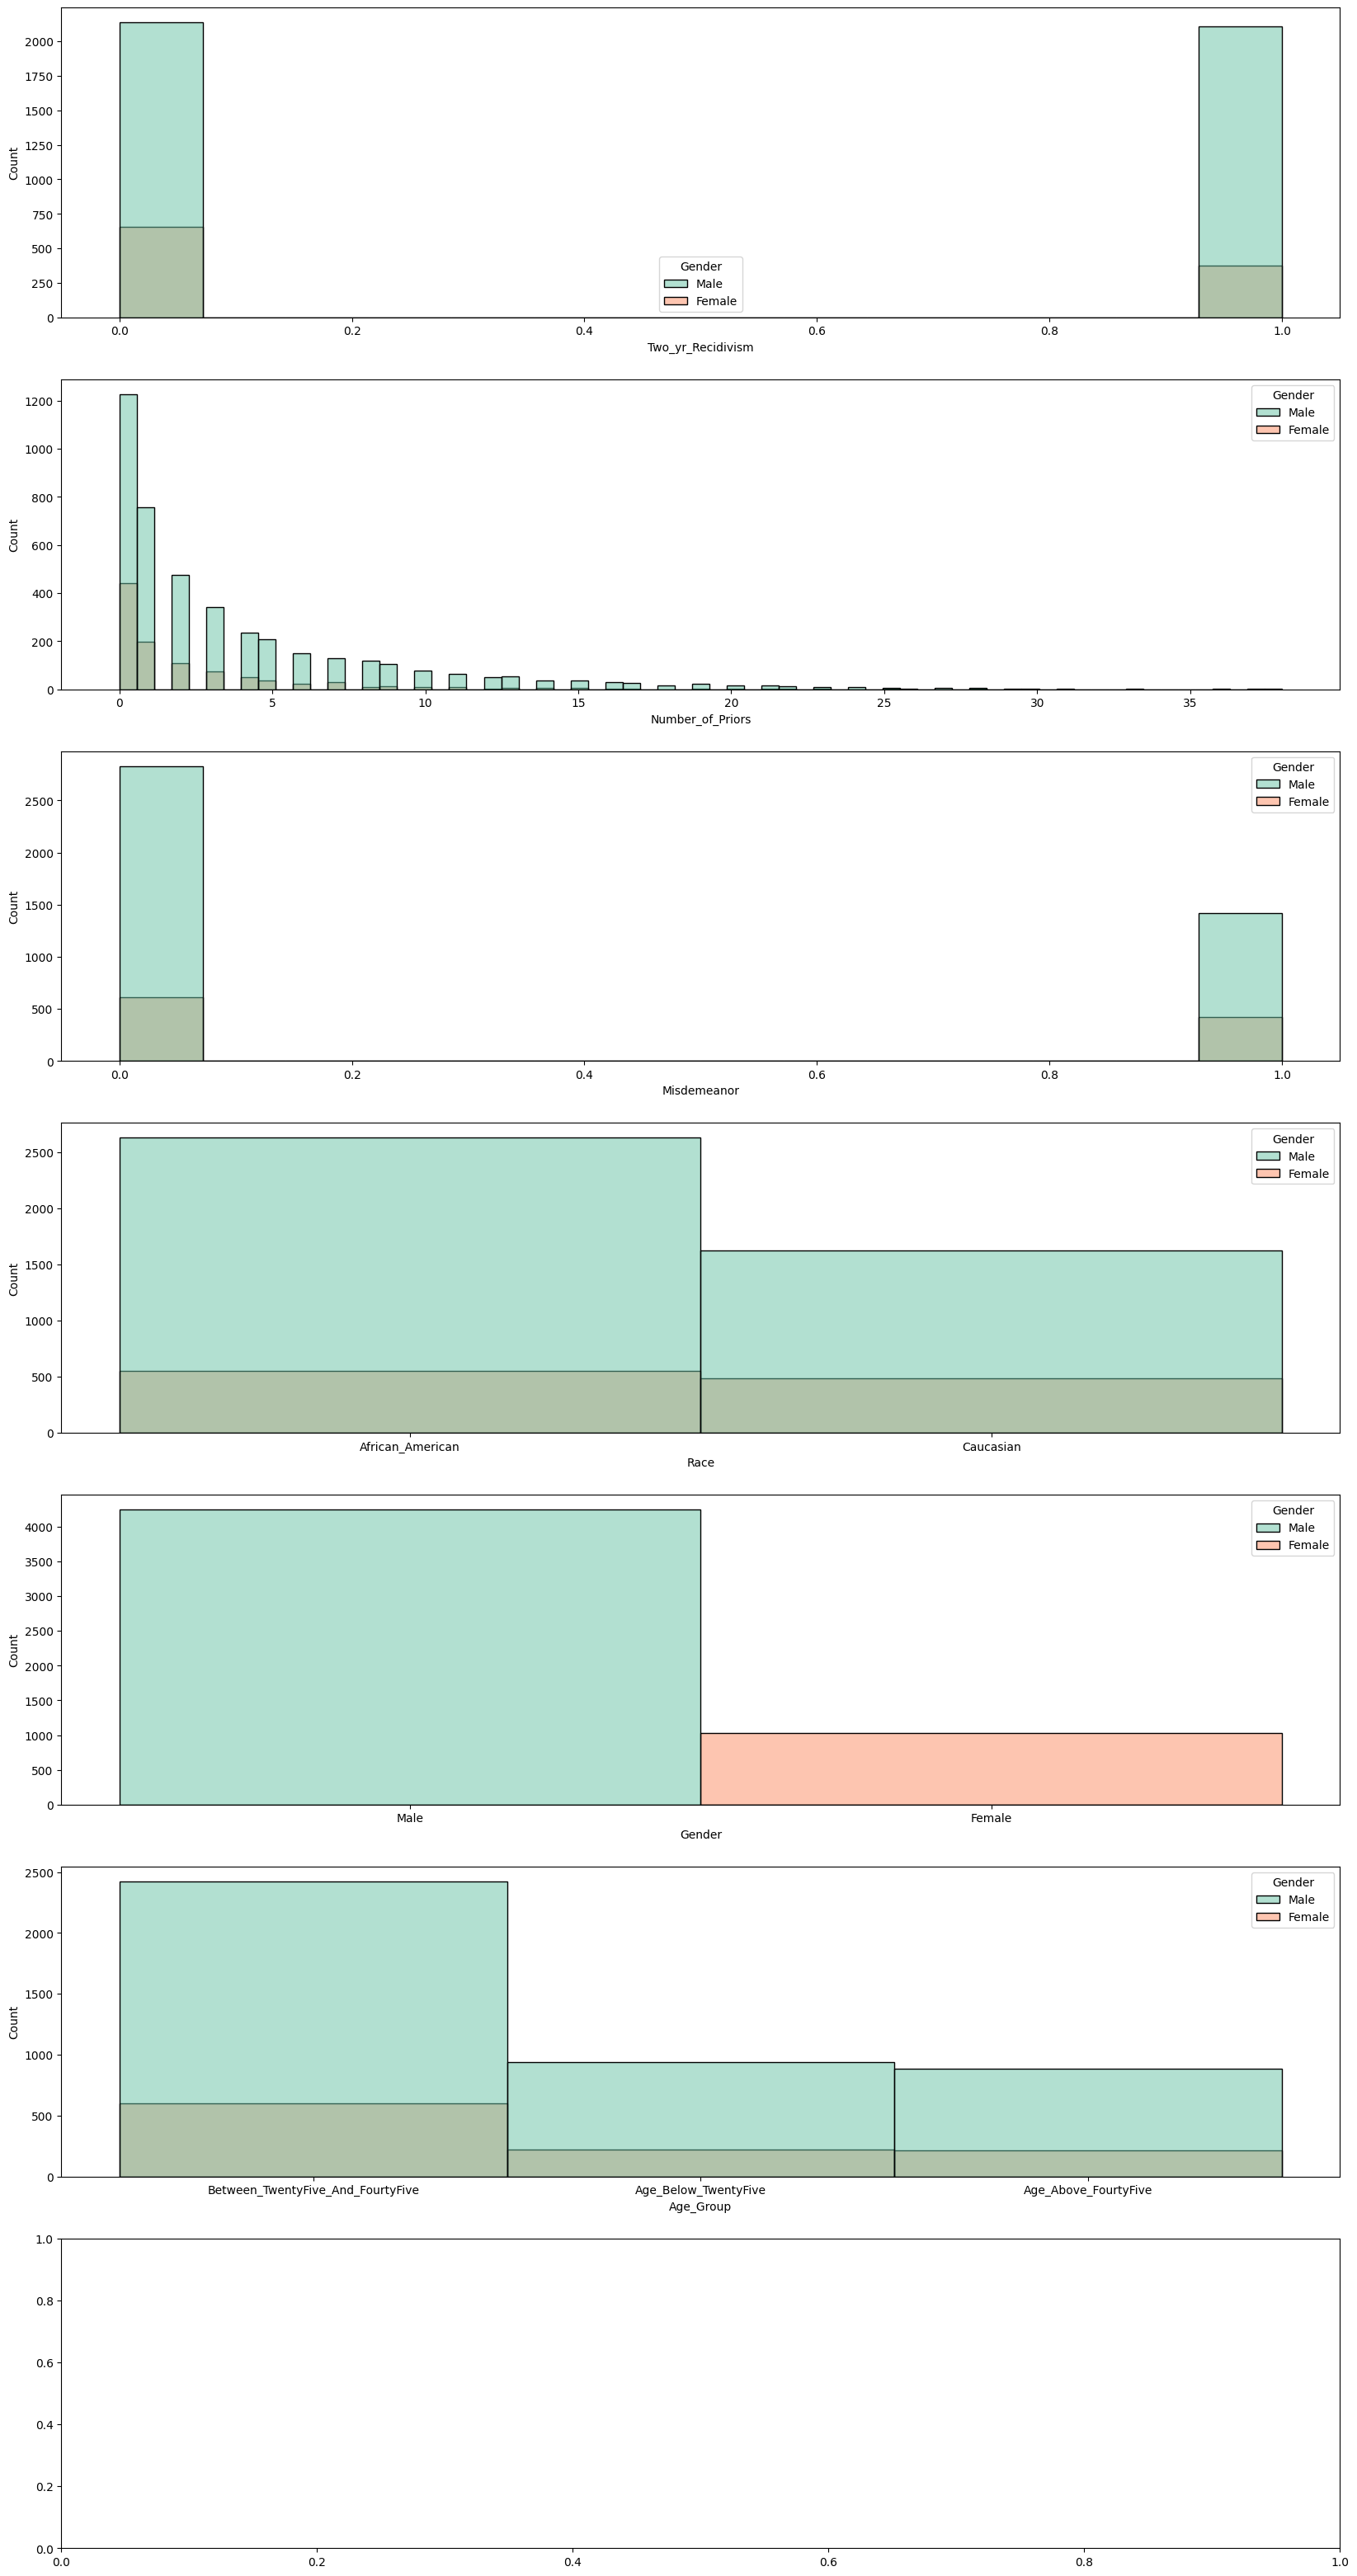

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns
# plot feature distributions for both genders in one plot
fig, axes = plt.subplots(7, figsize=(20, 40))
for i, feature in enumerate(df_recidivism.columns):
    sns.histplot(data=df_recidivism, x=feature, hue='Gender', ax=axes[i], palette='Set2')
plt.show()

In [185]:
# one hot encode data
dummies_df_recividism = pd.get_dummies(df_recidivism, columns=cat_cols, drop_first=True)
# remove target variable from features
labels = dummies_df_recividism.Two_yr_Recidivism
features = dummies_df_recividism.drop("Two_yr_Recidivism",axis=1)

features = features[["Number_of_Priors", "Misdemeanor", "Age_Group_Age_Below_TwentyFive", "Age_Group_Between_TwentyFive_And_FourtyFive", "Race_Caucasian", "Gender_Male"]]

# identify protected groups
indices = []
for i, f in enumerate(features.columns):
    if ("Race" in f) or ("Gender" in f):
        print("Column ID: %s" %i, "(%s)"%f)
        indices.append(i)

print(indices)

groups = features.iloc[:, indices]

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)

Column ID: 4 (Race_Caucasian)
Column ID: 5 (Gender_Male)
[4, 5]


In [186]:
## last columns of our data contains the protected features
protected = X_train[:,-2:] 
nonprotected = X_train[:,:-2]

protected_test = X_test[:,-2:]
nonprotected_test = X_test[:,:-2]

In [187]:
# run logistic regression on nonprotected groups
def sigmoid(x):
    """
    This is logistic regression
    f = 1/(1+exp(-beta^T * x))
    This function assumes as input that you have already multiplied beta and X together
    """
    return 1/(1+np.exp(-x))

def logistic_loss(y_true, y_pred, eps = 1e-9):
    """
    Loss for the logistic regression, y_preds are probabilities
    eps: epsilon for stability
    """
    return -np.mean(y_true*np.log(y_pred + eps)+(1-y_true)*np.log(1-y_pred + eps))
    
def l2_loss(beta):
    """
    L2-Regularisation
    """
    return np.linalg.norm(beta)

def compute_gradient(beta, X, y_true, _gamma):
    """Calculate the gradient - used for finding the best beta values. 
       You do not need to use groups and lambda (fmin_tnc expects same input as in func, that's why they are included here)"""
    grad = np.zeros(beta.shape)
    m = X.shape[0]
    y_pred = np.array(sigmoid(X.dot(beta)))
    
    for i in range(len(grad)):
        # skip intercept
        if i == 0:
            grad[i] = (1/m) * (y_pred - y_true).dot(X[:,i]) 
        else:
            grad[i] = (1/m) * (y_pred - y_true).dot(X[:,i]) + 2* _gamma *beta[i]
    return grad

def compute_cost(beta , X, y_true, _gamma):
    """Computes cost function with constraints"""
    y_pred = sigmoid(X.dot(beta)) 
    cost = logistic_loss(y_true, y_pred) + _gamma*l2_loss(beta[1:])
    return cost

def cross_validate(X, y, penalty, k=5):
    """
    Performs k-fold cross-validation on logistic regression with L2-penalty
    
    X: feature matrix
    y: target variable
    penalty: L2-penalty value
    k: number of folds (default=5)
    
    Returns: average accuracy across all folds
    """
    n_samples = len(y)
    fold_size = n_samples // k
    
    accuracy_sum = 0
    
    for i in range(k):
        # split the data into training and validation sets
        val_start = i * fold_size
        val_end = (i + 1) * fold_size
        X_val = X[val_start:val_end]
        y_val = y[val_start:val_end]
        X_train = np.concatenate([X[:val_start], X[val_end:]])
        y_train = np.concatenate([y[:val_start], y[val_end:]])
        
        # fit logistic regression optimization function
        beta = np.random.rand(X.shape[1])
        result = opt.fmin_tnc(func=compute_cost, x0=beta, approx_grad = True, maxfun = 1000,
                            args = (X_train,y_train, penalty), ftol=1e-4, xtol=1e-4)
        beta = result[0]

        
        # evaluate model on validation set
        y_pred = sigmoid(X_val.dot(beta))
        y_pred = np.where(y_pred > 0.5, 1, 0)
        accuracy = np.mean(y_pred == y_val)
        accuracy_sum += accuracy
        
        
    accuracy_avg = accuracy_sum / k
    
    return accuracy_avg

In [188]:
np.random.seed(0)
penalties = [0.001, 0.01, 0.02, 0.05, 0.1, 0,2, 0.5, 1]
best_penalty = None
best_accuracy = 0

for penalty in penalties:
    accuracy_avg = cross_validate(nonprotected, y_train, penalty)
    if accuracy_avg > best_accuracy:
        best_accuracy = accuracy_avg
        best_penalty = penalty
        
print("Best L2-penalty:", best_penalty)
print("Best accuracy:", best_accuracy)

Best L2-penalty: 0.05
Best accuracy: 0.6360433604336043


In [189]:
# Evaluate the overall performance of the best model on the Test Set (use appropriate metrics) + report uncertainty
# function for balanced accuracy
def balanced_accuracy(y_true, y_pred):
    """
    Calculates the balanced accuracy score
    """
    TP = np.sum(np.logical_and(y_pred == 1, y_true == 1))
    FP = np.sum(np.logical_and(y_pred == 1, y_true == 0))
    TN = np.sum(np.logical_and(y_pred == 0, y_true == 0))
    FN = np.sum(np.logical_and(y_pred == 0, y_true == 1))
    
    accuracy = (TP/(TP+FN) + TN/(TN+FP)) / 2
    return accuracy

beta = np.random.rand(nonprotected.shape[1])
result = opt.fmin_tnc(func=compute_cost, x0=beta, approx_grad = True, maxfun = 1000,
                            args = (nonprotected, y_train, best_penalty), ftol=1e-4, xtol=1e-4)
beta = result[0]

# evaluate the model on the test set using balanced accuracy
y_pred = sigmoid(nonprotected_test.dot(beta))
y_pred = np.where(y_pred > 0.5, 1, 0)
accuracy = balanced_accuracy(y_test, y_pred)
print("Balanced accuracy on test set:", accuracy)

# calculate precision by hand
TP = np.sum(np.logical_and(y_pred == 1, y_test == 1))
FP = np.sum(np.logical_and(y_pred == 1, y_test == 0))
precision = TP / (TP + FP)
print("Precision on test set:", precision)

# calculate recall by hand
TP = np.sum(np.logical_and(y_pred == 1, y_test == 1))
FN = np.sum(np.logical_and(y_pred == 0, y_test == 1))
recall = TP / (TP + FN)
print("Recall on test set:", recall)

# calculate F1 score by hand
F1 = 2 * (precision * recall) / (precision + recall)
print("F1 score on test set:", F1)

# calculate uncertainty by bootstrapping
n_bootstraps = 1000
bootstrapped_scores = []
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = np.random.randint(low=0, high=len(y_pred), size=len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = balanced_accuracy(y_test[indices], y_pred[indices])
    bootstrapped_scores.append(score)

print("Confidence interval for the accuracy score: [{:0.3f} - {:0.3}]".format(
    np.percentile(bootstrapped_scores, 2.5),
    np.percentile(bootstrapped_scores, 97.5)))

Balanced accuracy on test set: 0.6366338669974484
Precision on test set: 0.5627490039840638
Recall on test set: 0.7825484764542936
F1 score on test set: 0.6546929316338355
Confidence interval for the accuracy score: [0.614 - 0.659]


In [71]:
# caluclate statistical parity, equalized odds and equalized outcome for all groups
def calculate_metrics(y_true, y_pred, groups):
    """
    Calculate statistical parity, equalized odds and equalized outcome for all groups
    """
    metrics = {}
    for group in groups:
        for i in [0,1]:
            group_idx = np.where(groups[group] == i)
            y_true_group = y_true[group_idx]
            y_pred_group = y_pred[group_idx]
            g = group + str(i)
            metrics[g] = {}
            metrics[g]['statistical_parity'] = np.mean(y_pred_group)
            metrics[g]['equalized_odds'] = np.mean(y_pred_group[y_true_group == 1]) - np.mean(y_pred_group[y_true_group == 0])
            metrics[g]['equalized_outcome'] = np.mean(y_pred_group[y_true_group == 1])
    return metrics

def calculate_balanced_accuracy_groups(y_true, y_pred, groups):
    """
    Calculate balanced accuracy for all groups
    """
    metrics = {}
    for group in groups:
        for i in [0,1]:
            group_idx = np.where(groups[group] == i)
            y_true_group = y_true[group_idx]
            y_pred_group = y_pred[group_idx]
            g = group + str(i)
            metrics[g] = {}
            metrics[g]['balanced_accuracy'] = balanced_accuracy(y_true_group, y_pred_group)
    return metrics

In [190]:
# calculate metrics for all groups
y_test_ = np.array([1 if y else 0 for y in y_test])
metrics = calculate_metrics(y_test, y_pred, group_test)
for key, value in metrics.items():
    print(key, ":",  value)

Race_Caucasian0 : {'statistical_parity': 0.7125, 'equalized_odds': 0.2756441419543024, 'equalized_outcome': 0.8491735537190083}
Race_Caucasian1 : {'statistical_parity': 0.5128205128205128, 'equalized_odds': 0.21700701005790923, 'equalized_outcome': 0.6470588235294118}
Gender_Male0 : {'statistical_parity': 0.48148148148148145, 'equalized_odds': 0.29850746268656714, 'equalized_outcome': 0.6666666666666666}
Gender_Male1 : {'statistical_parity': 0.6730158730158731, 'equalized_odds': 0.2541502605199286, 'equalized_outcome': 0.8063439065108514}


## Fair PCA

In [ ]:
# apply fair PCA 

In [ ]:
# run logistic regression on fair PCA data

In [ ]:
# calculate fairness metrics and accuracy scores

In [ ]:
# compare results amongst all datasets

## Loan defaulting

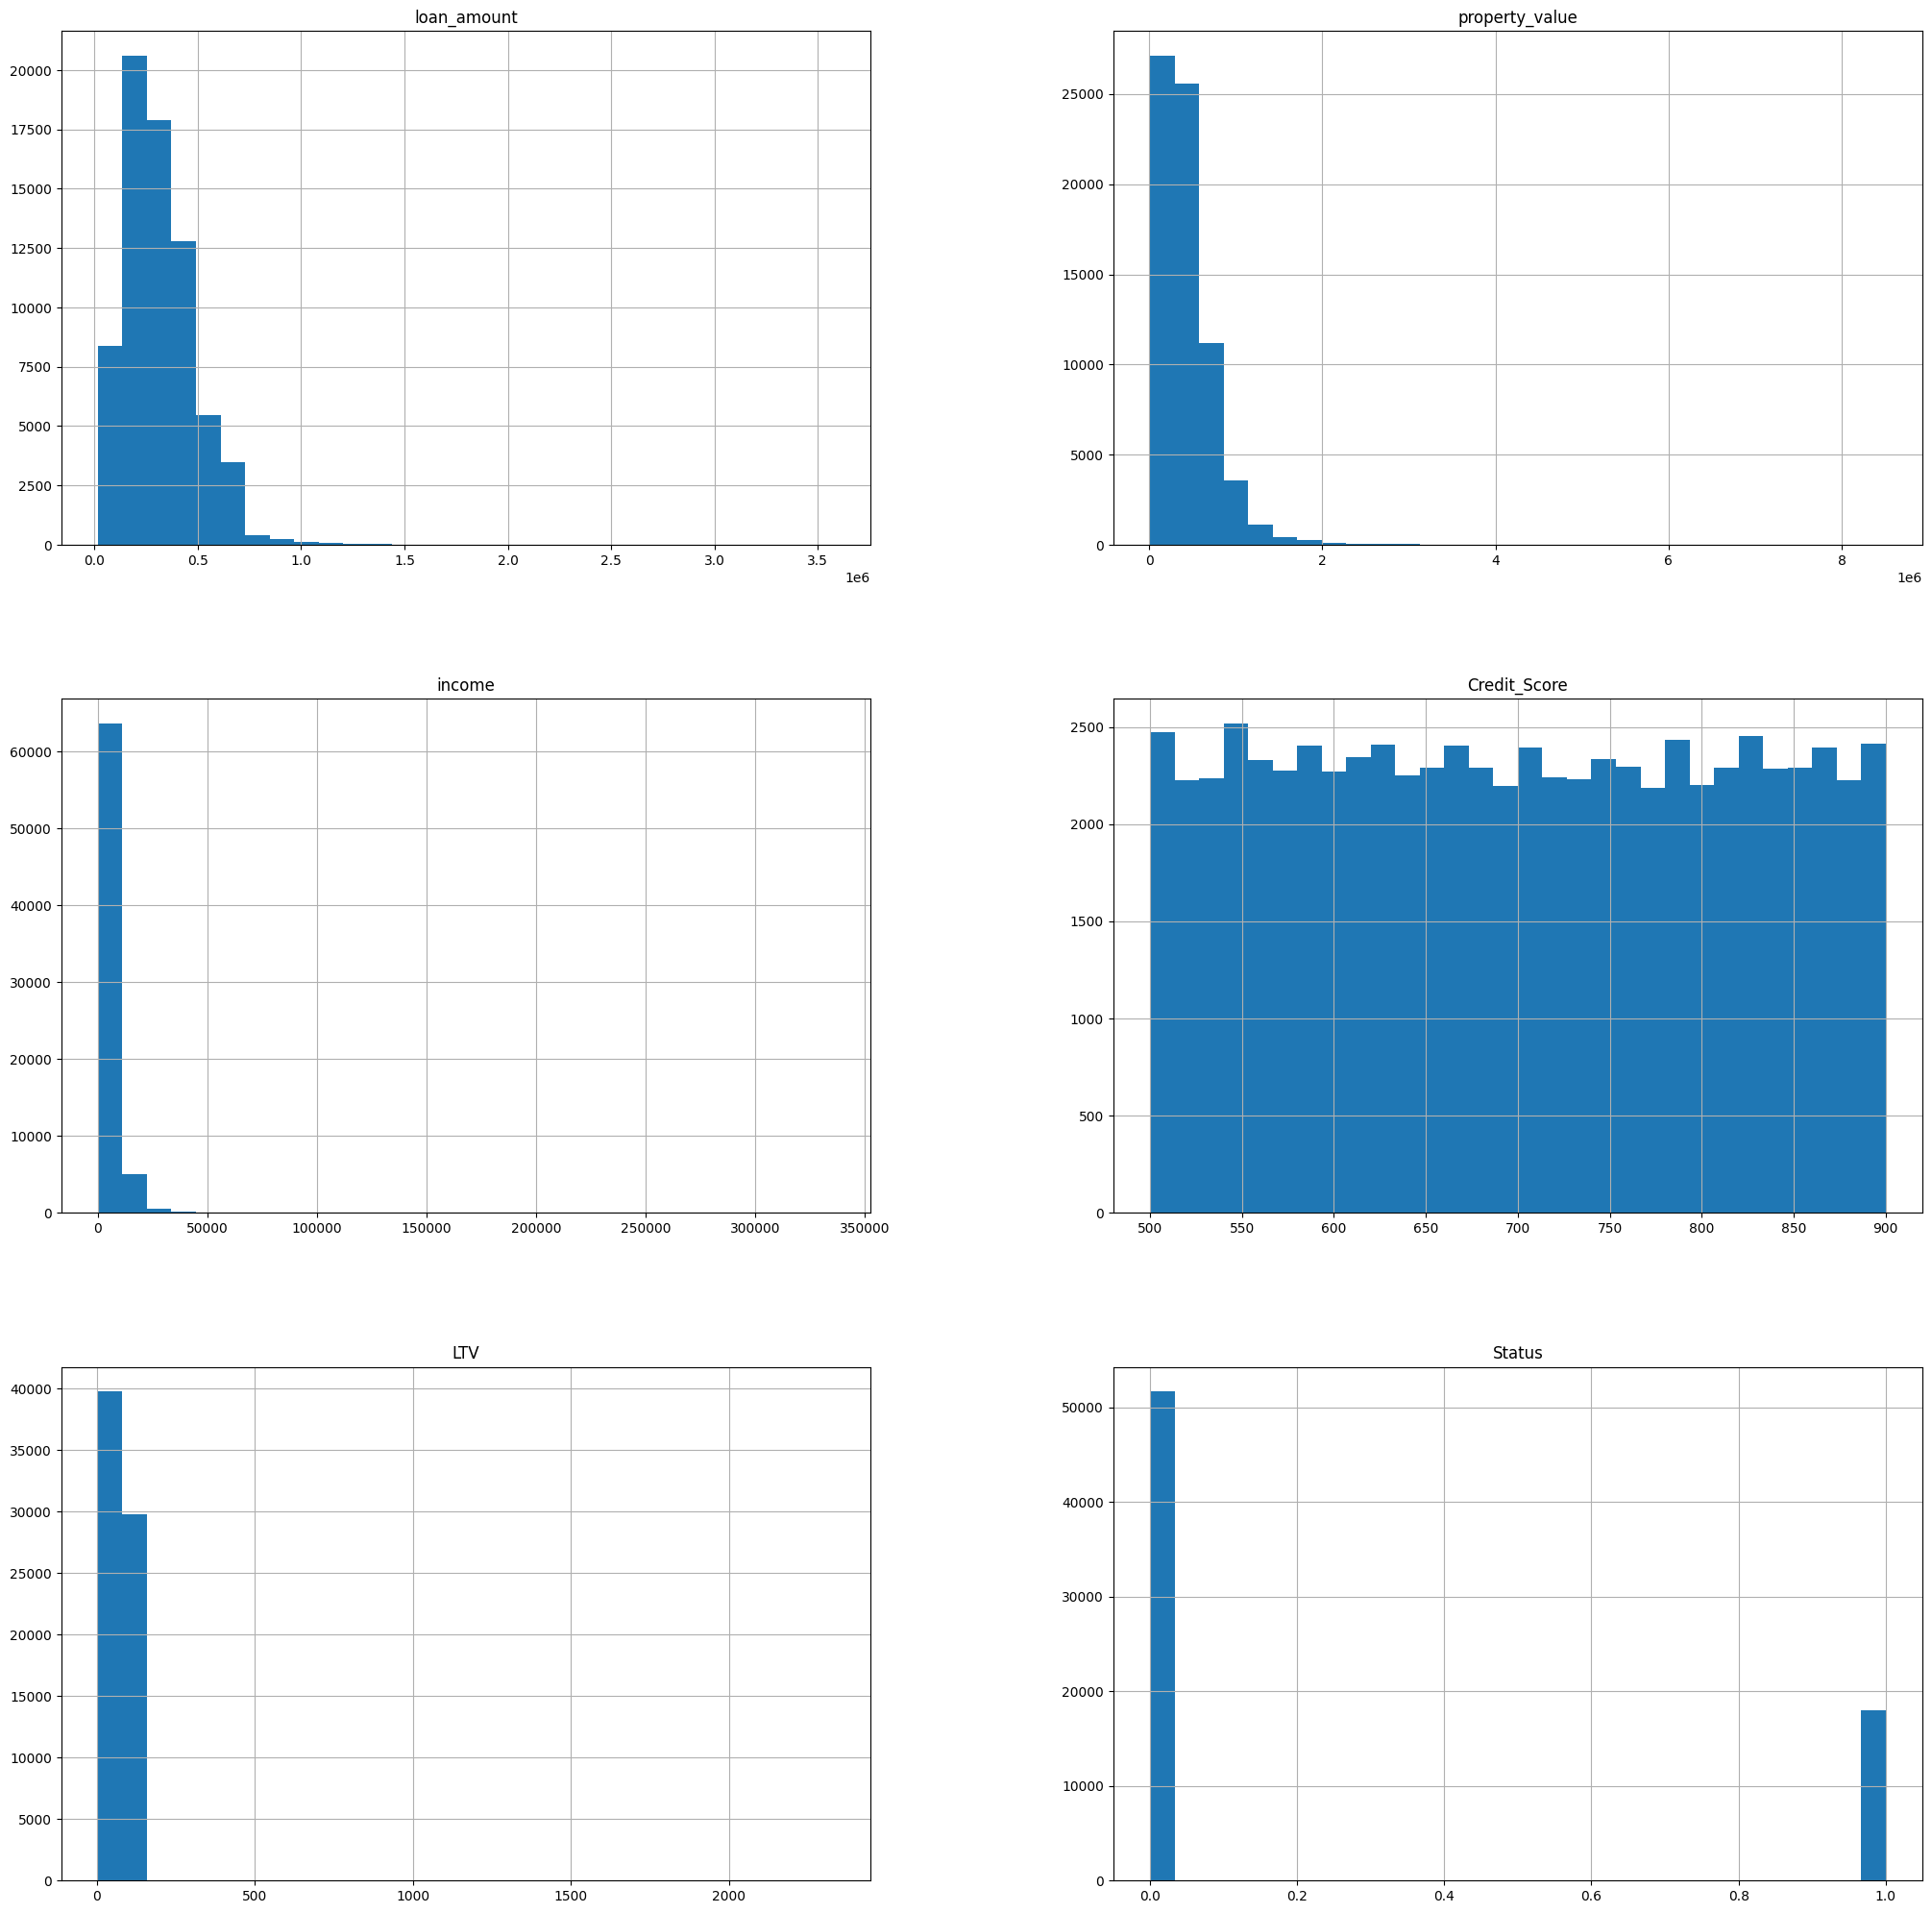

In [156]:
df_original = pd.read_csv('data/loan_default.csv')

# Dataset from https://www.kaggle.com/datasets/yasserh/loan-default-dataset?datasetId=1897041&sortBy=voteCount,
# Protected attribute is Gender
# Object is status, 0 or 1 (default or not)

# Drop all rows with nan
df_loans = df_original.drop(['Region', 'Security_Type', 'dtir1', 'total_units', 'Secured_by',
              'term', 'open_credit', 'year', 'rate_of_interest', 'Interest_rate_spread',
              'Upfront_charges', 'loan_limit', 'construction_type',
              'co-applicant_credit_type', 'ID'], axis=1)

# Drop all rows from column 'Gender' that have 'Sex Not Available'
df_loans = df_loans[(df_loans['Gender'] != 'Sex Not Available') & (df_loans['Gender'] != 'Joint')]

# Replace missing values with mode
df_loans['approv_in_adv'].fillna(df_loans['approv_in_adv'].mode()[0], inplace=True)
df_loans['loan_purpose'].fillna(df_loans['loan_purpose'].mode()[0], inplace=True)
df_loans['Neg_ammortization'].fillna(df_loans['Neg_ammortization'].mode()[0], inplace=True)
df_loans['property_value'].fillna(df_loans['property_value'].mode()[0], inplace=True)
df_loans['income'].fillna(df_loans['income'].mode()[0], inplace=True)
df_loans['LTV'].fillna(df_loans['LTV'].mode()[0], inplace=True)

df_loans.hist(bins=30, figsize=(25,25))
plt.show()

In [157]:
# get list of categorical columns
num_cols = df_loans._get_numeric_data().columns
cat_cols = list(set(df_loans.columns) - set(num_cols))

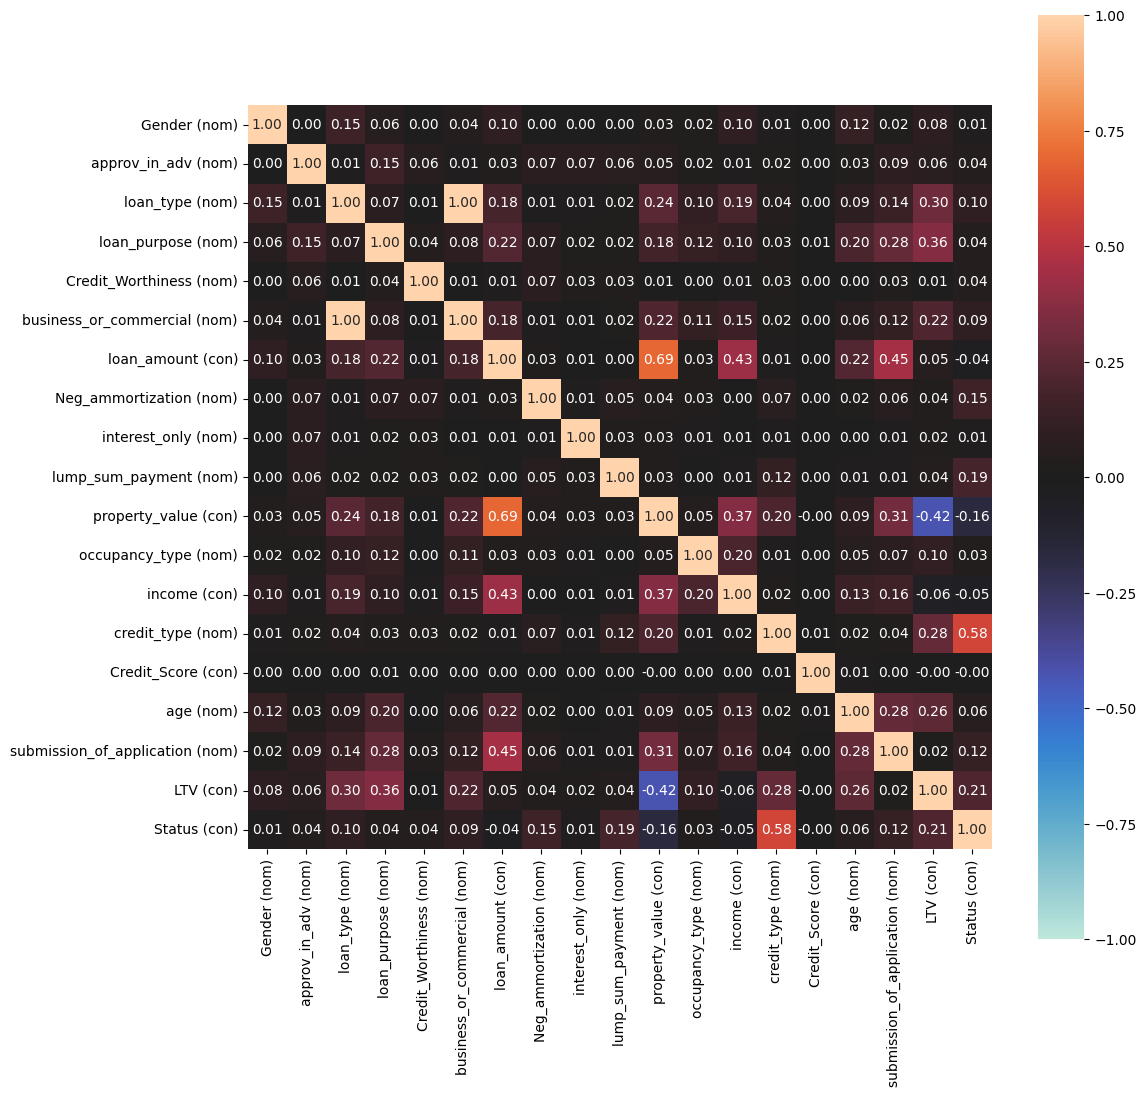

In [158]:
dython.nominal.associations(df_loans, nominal_columns=cat_cols, mark_columns=True, figsize=(12,12));

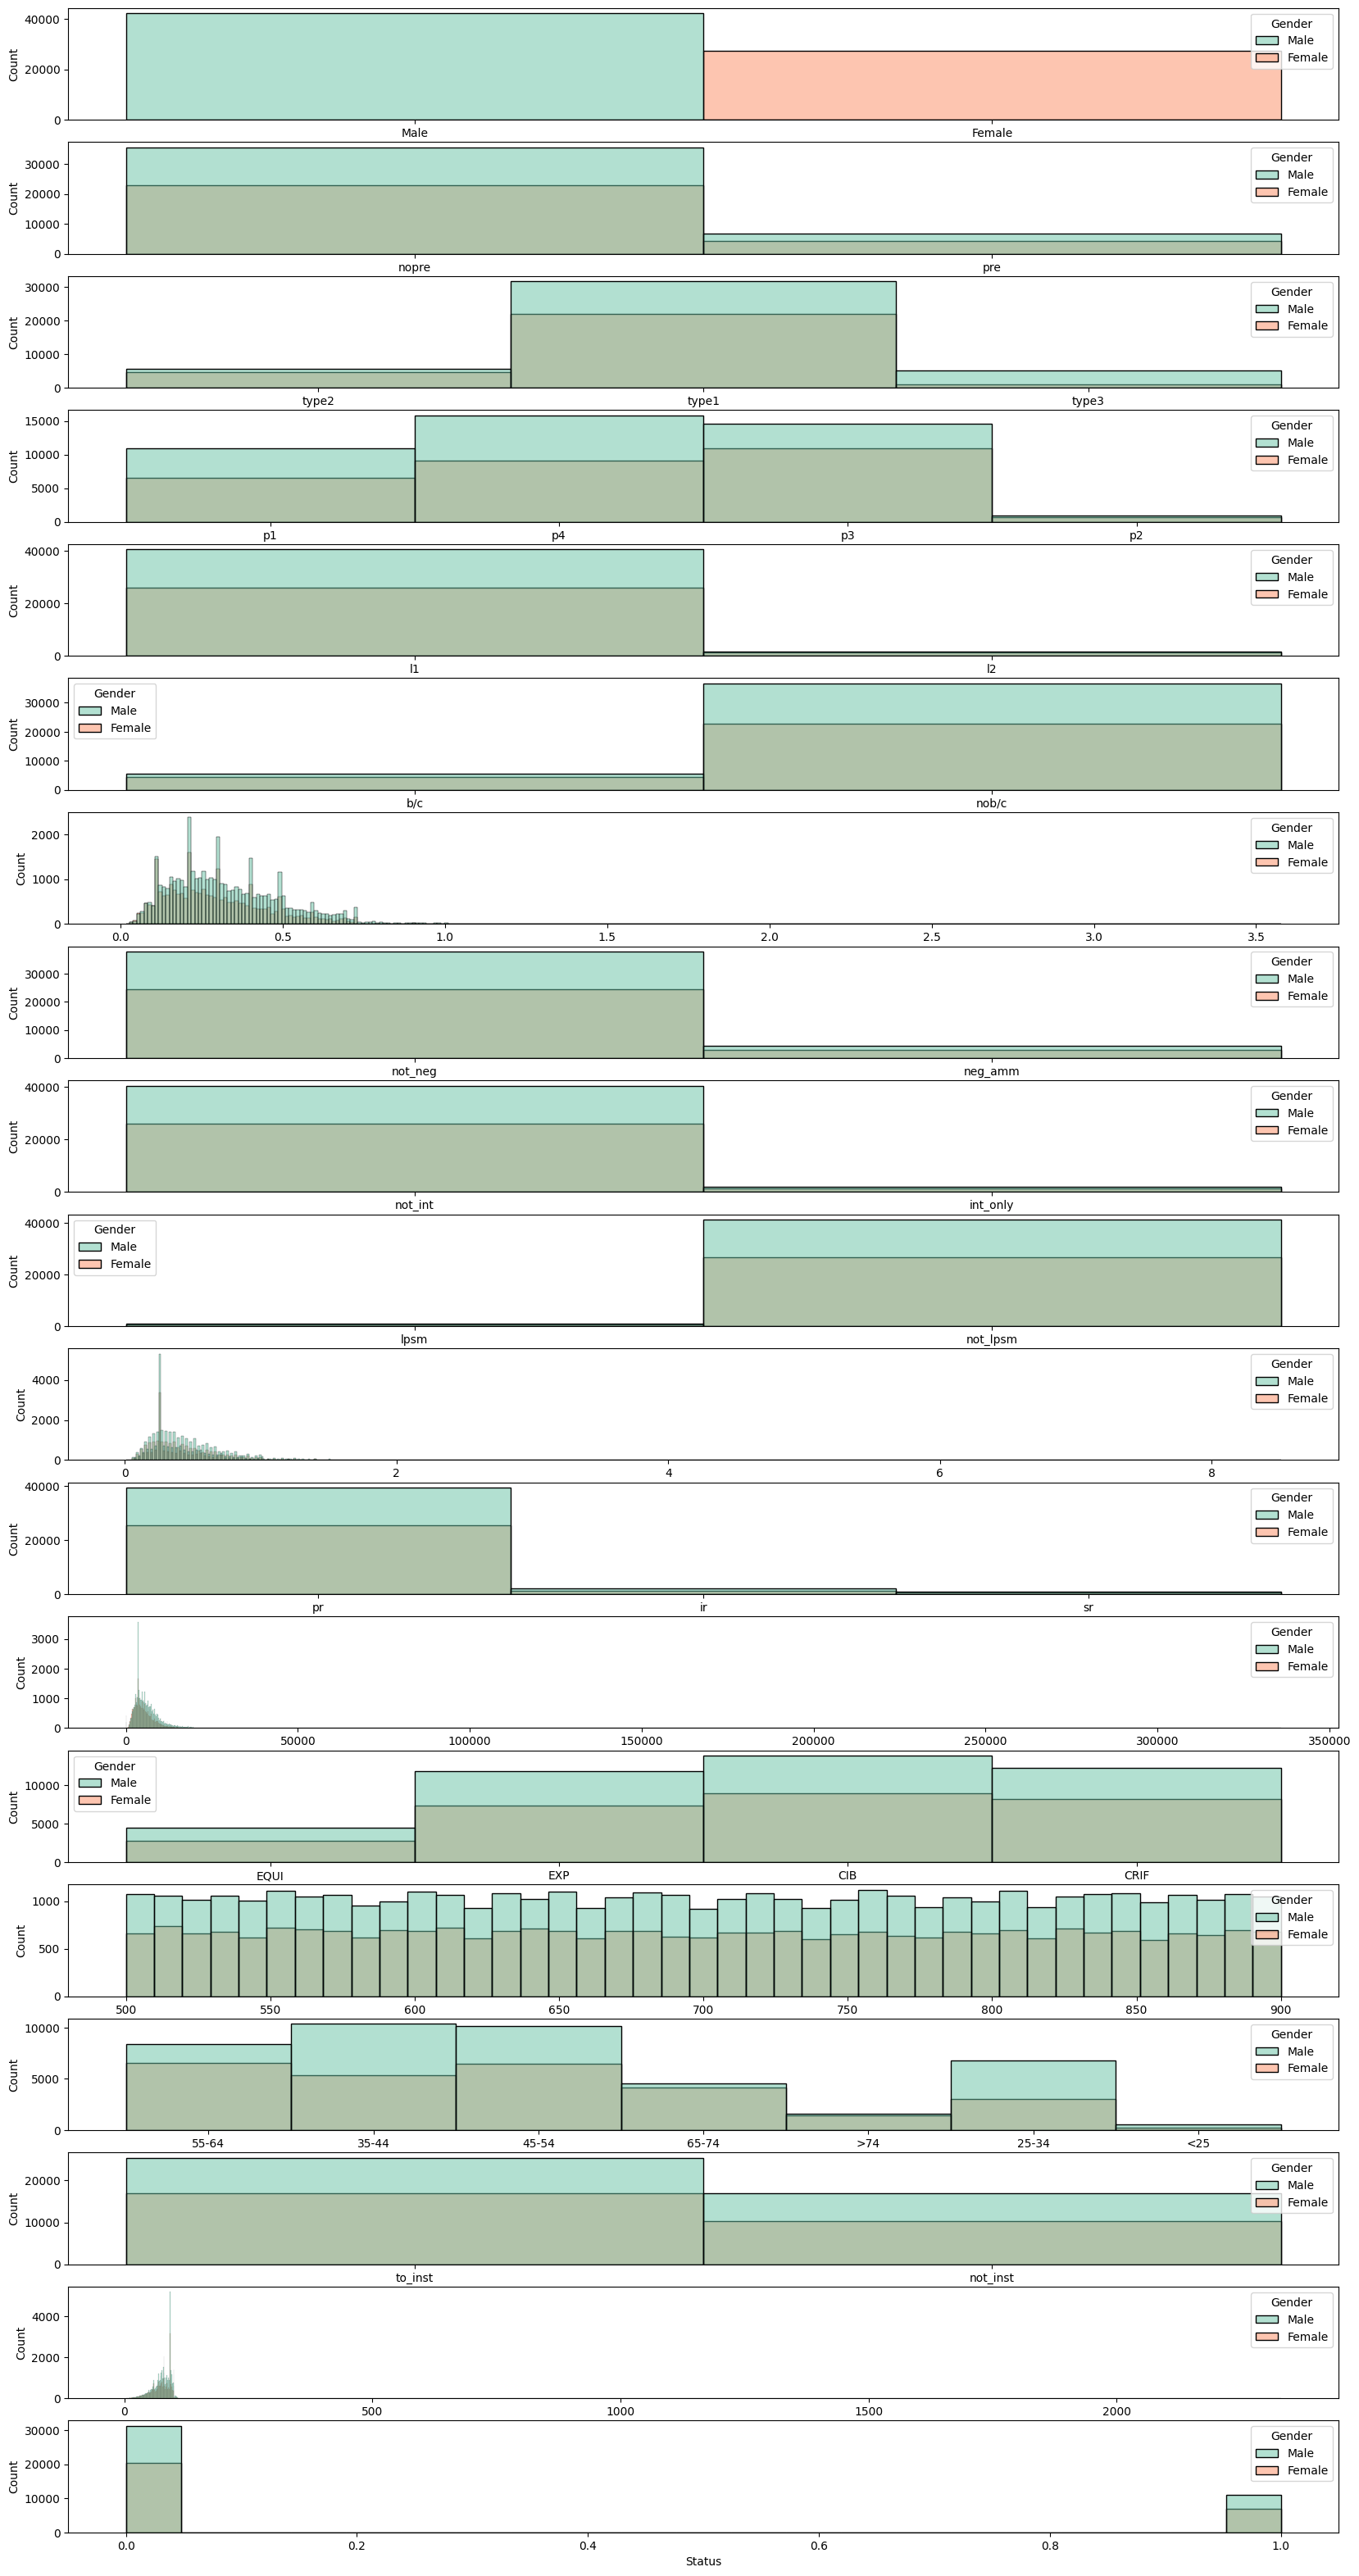

In [159]:
# plot feature distributions for both genders in one plot
fig, axes = plt.subplots(19, figsize=(20, 40))
for i, feature in enumerate(df_loans.columns):
    sns.histplot(data=df_loans, x=feature, hue='Gender', ax=axes[i], palette='Set2')
plt.show()

In [172]:
# one hot encode data
dummies_df_loans = pd.get_dummies(df_loans, columns=cat_cols, drop_first=True)
# remove target variable from features
labels = dummies_df_loans.Status
features = dummies_df_loans.drop("Status",axis=1)

# identify protected groups
indices = []
for i, f in enumerate(features.columns):
    if ("Gender" in f):
        print("Column ID: %s" %i, "(%s)"%f)
        indices.append(i)

print(indices)

groups = features.iloc[:, indices]

X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)

Column ID: 6 (Gender_Male)
[6]


In [173]:
## remove column 6 from X_train and X_test and save it as protected variable
protected = X_train[:,6]
nonprotected = np.delete(X_train, 6, 1)

protected_test = X_test[:,6]
nonprotected_test = np.delete(X_test, 6, 1)

In [142]:
penalties = [0.001, 0.01, 0.1, 1, 5]
best_penalty = None
best_accuracy = 0

for penalty in penalties:
    print("L2-penalty:", penalty)
    accuracy_avg = cross_validate(nonprotected, y_train, penalty)
    print("Accuracy:", accuracy_avg)
    if accuracy_avg > best_accuracy:
        best_accuracy = accuracy_avg
        best_penalty = penalty
        
print("Best L2-penalty:", best_penalty)
print("Best accuracy:", best_accuracy)

L2-penalty: 0.001


C:\Users\Juliu\AppData\Local\Temp\ipykernel_23756\2607233604.py:8: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Accuracy: 0.48886608517188296
L2-penalty: 0.01
Accuracy: 0.8017650076962545
L2-penalty: 0.1
Accuracy: 0.5745100051308363
L2-penalty: 1
Accuracy: 0.6929091841970242
L2-penalty: 5
Accuracy: 0.6935248845561827
Best L2-penalty: 0.01
Best accuracy: 0.8017650076962545


In [174]:
# Evaluate the overall performance of the best model on the Test Set (use appropriate metrics) + report uncertainty
# function for balanced accuracy
beta = np.random.rand(nonprotected.shape[1])
result = opt.fmin_tnc(func=compute_cost, x0=beta, approx_grad = True, maxfun = 1000,
                            args = (nonprotected, y_train, best_penalty), ftol=1e-4, xtol=1e-4)
beta = result[0]

# evaluate the model on the test set using balanced accuracy
y_pred = sigmoid(nonprotected_test.dot(beta))
y_pred = np.where(y_pred > 0.5, 1, 0)
accuracy = balanced_accuracy(y_test, y_pred)
print("Balanced accuracy on test set:", accuracy)

# calculate precision by hand
TP = np.sum(np.logical_and(y_pred == 1, y_test == 1))
FP = np.sum(np.logical_and(y_pred == 1, y_test == 0))
precision = TP / (TP + FP)
print("Precision on test set:", precision)

# calculate recall by hand
TP = np.sum(np.logical_and(y_pred == 1, y_test == 1))
FN = np.sum(np.logical_and(y_pred == 0, y_test == 1))
recall = TP / (TP + FN)
print("Recall on test set:", recall)

# calculate F1 score by hand
F1 = 2 * (precision * recall) / (precision + recall)
print("F1 score on test set:", F1)

# calculate uncertainty by bootstrapping
n_bootstraps = 1000
bootstrapped_scores = []
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = np.random.randint(low=0, high=len(y_pred), size=len(y_pred))
    if len(np.unique(y_test[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue

    score = balanced_accuracy(y_test[indices], y_pred[indices])
    bootstrapped_scores.append(score)

print("Confidence interval for the accuracy score: [{:0.3f} - {:0.3}]".format(
    np.percentile(bootstrapped_scores, 2.5),
    np.percentile(bootstrapped_scores, 97.5)))

C:\Users\Juliu\AppData\Local\Temp\ipykernel_23756\2607233604.py:8: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


Balanced accuracy on test set: 0.622496270293088
Precision on test set: 0.9341111873713109
Recall on test set: 0.2511997046880768
F1 score on test set: 0.39592727272727274
Confidence interval for the accuracy score: [0.616 - 0.628]


In [179]:
# calculate metrics for all groups
y_test_ = np.array([1 if y else 0 for y in y_test])
metrics = calculate_metrics(y_test_, y_pred, group_test)
for key, value in metrics.items():
    print(key, ":", value)

Gender_Male0 : {'statistical_parity': 0.05990279465370595, 'equalized_odds': 0.22575098594594073, 'equalized_outcome': 0.228516562650024}
Gender_Male1 : {'statistical_parity': 0.07618144460249723, 'equalized_odds': 0.2568900119100231, 'equalized_outcome': 0.2653673163418291}


In [178]:
features["Gender_Male"]

1         1
2         1
3         1
7         0
10        1
         ..
148663    1
148666    1
148667    1
148668    0
148669    0
Name: Gender_Male, Length: 69612, dtype: uint8